### Loading and Exploring Data

In [1]:
library(knitr)
library(ggplot2)
library(plyr)
library(dplyr)
library(corrplot)
library(caret)
library(gridExtra)
library(scales)
library(Rmisc)
# library(ggrepel)
library(randomForest)
library(psych)
library(xgboost)

options(warn=-1)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

corrplot 0.84 loaded
Loading required package: lattice

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘psych’

The following object is ma

In [2]:
train <- read.csv("train.csv", stringsAsFactors = F)
test <- read.csv("test.csv", stringsAsFactors = F)

In [3]:
head(train)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


The train dataset consist of character and integer variables. Most of the character variables are actually (ordinal) factors, but I chose to read them into R as character strings as most of them require cleaning and/or feature engineering first.

In [4]:
dim(train)

[1] 1460   81

In [5]:
# display first 10 variables and the response variable

str(train[,c(1:10, 81)]) 

'data.frame':	1460 obs. of  11 variables:
 $ Id         : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning   : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage: int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea    : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street     : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley      : chr  NA NA NA NA ...
 $ LotShape   : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour: chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities  : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ SalePrice  : int  208500 181500 223500 140000 250000 143000 307000 200000 129900 118000 ...


In [6]:
# Getting rid of the IDs but keeping the test IDs in a vector. These are needed to compose the submission file

test_labels <- test$Id
test$Id <- NULL
train$Id <- NULL

In [7]:
test$SalePrice <- NA
all <- rbind(train, test)
dim(all)

[1] 2919   80

Without the Id’s, the dataframe consists of 79 predictors and our response variable SalePrice.

---

### Exploring some of the most important variables

As you can see, the sale prices are right skewed. This was expected as few people can afford very expensive houses. I will keep this in mind, and take measures before modeling.

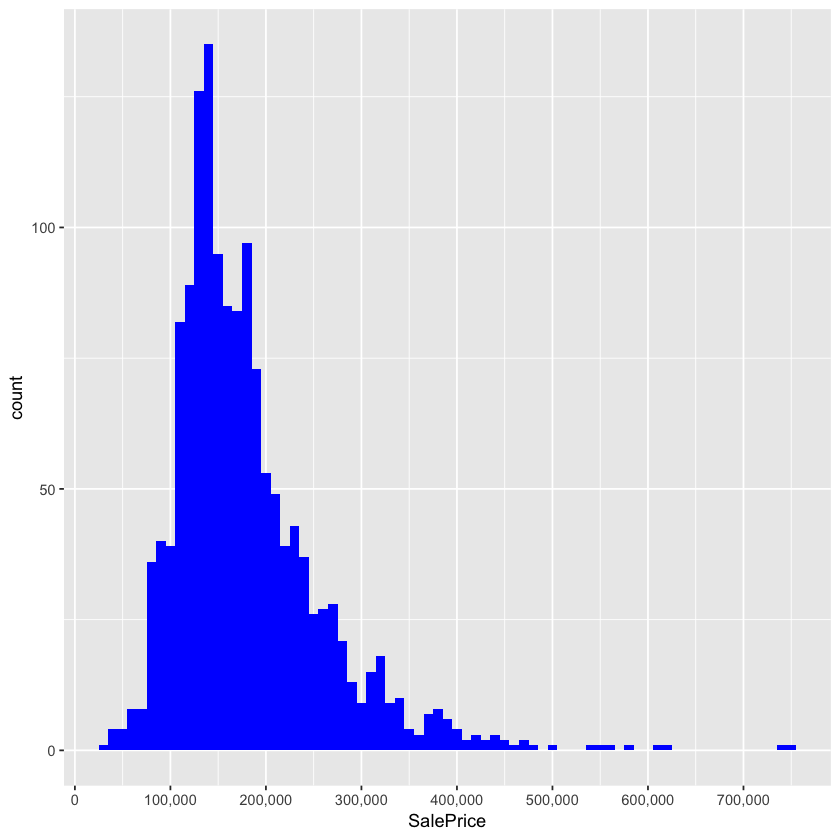

In [20]:
ggplot(data=all[!is.na(all$SalePrice),], aes(x=SalePrice)) +
    geom_histogram(fill="blue", binwidth = 10000) +
    scale_x_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

In [21]:
summary(all$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  34900  129975  163000  180921  214000  755000    1459 

The character variables need some work before I can use them. To get a feel for the dataset, I decided to first see which numeric variables have a high correlation with the SalePrice.

Altogether, there are 10 numeric variables with a correlation of at least 0.5 with SalePrice. All those correlations are positive:

In [22]:
numericVars <- which(sapply(all, is.numeric)) # index vector numeric variables
numericVarNames <- names(numericVars) # saving names vector for use later on
cat('There are', length(numericVars), 'numeric variables')

There are 37 numeric variables

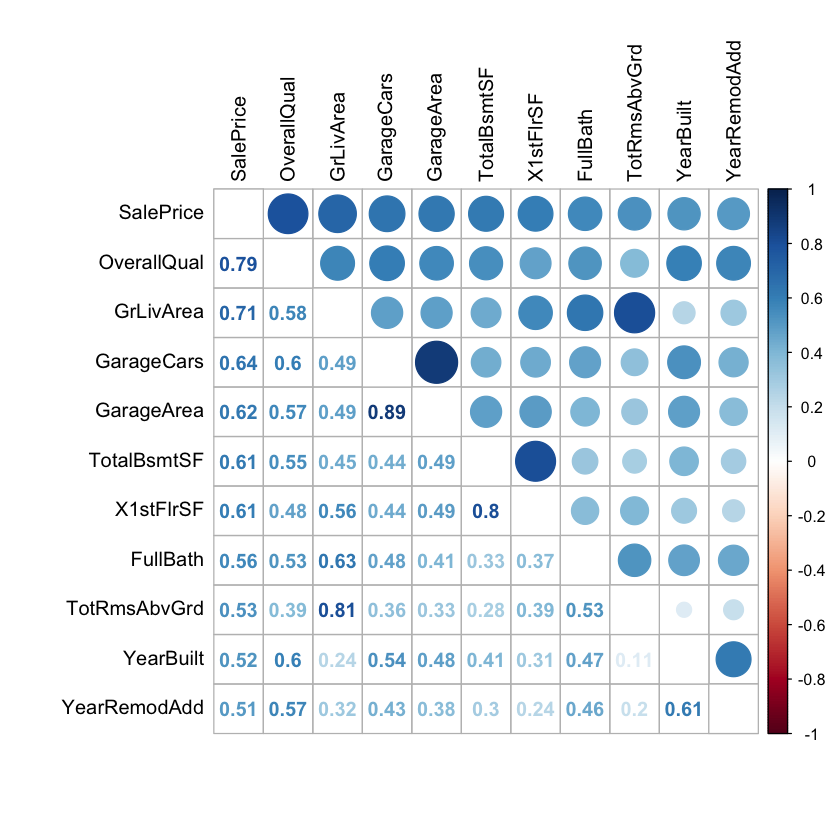

In [23]:
all_numVar <- all[, numericVars]
cor_numVar <- cor(all_numVar, use="pairwise.complete.obs") #correlations of all numeric variables

# sort on decreasing correlations with SalePrice
cor_sorted <- as.matrix(sort(cor_numVar[,'SalePrice'], decreasing = TRUE))
# select only high corelations
CorHigh <- names(which(apply(cor_sorted, 1, function(x) abs(x)>0.5)))
cor_numVar <- cor_numVar[CorHigh, CorHigh]

corrplot.mixed(cor_numVar, tl.col="black", tl.pos = "lt")

I will visualize the relation between SalePrice and the two predictors with the highest correlation with SalePrice; Overall Quality and the ‘Above Grade’ Living Area (this is the proportion of the house that is not in a basement).

It also becomes clear the multicollinearity is an issue. For example: the correlation between GarageCars and GarageArea is very high (0.89), and both have similar (high) correlations with SalePrice. 

The other 6 six variables with a correlation higher than 0.5 with SalePrice are: 
- TotalBsmtSF: Total square feet of basement area 
- 1stFlrSF: First Floor square feet 
- FullBath: Full bathrooms above grade 
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) 
- YearBuilt: Original construction date 
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

Overall Quality has the highest correlation with SalePrice among the numeric variables (0.79). It rates the overall material and finish of the house on a scale from 1 (very poor) to 10 (very excellent)Ж

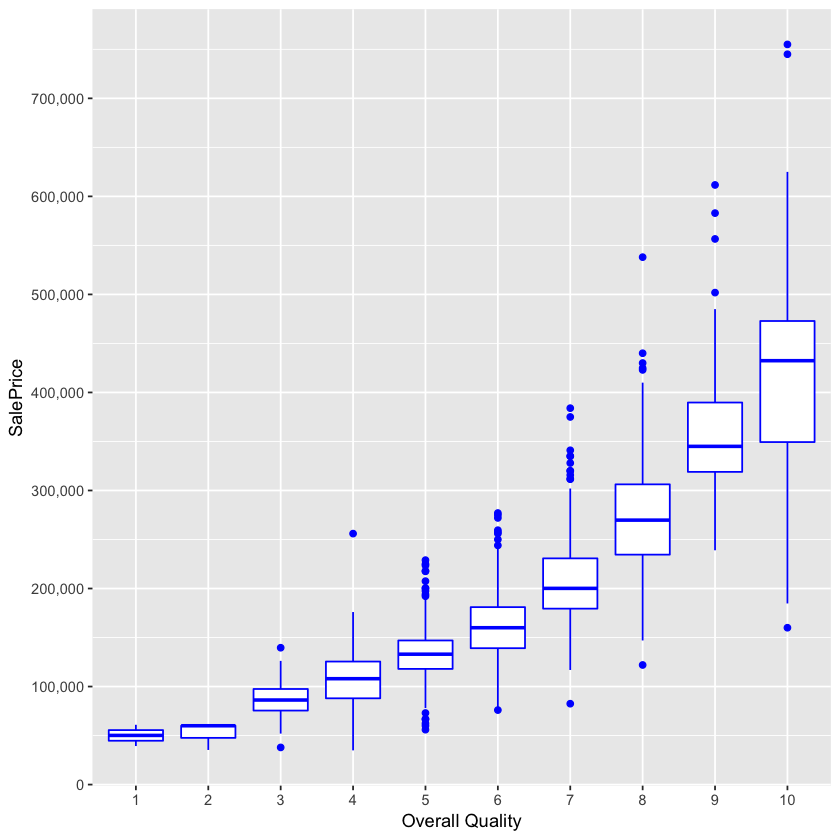

In [24]:
ggplot(data=all[!is.na(all$SalePrice),], 
       aes(x=factor(OverallQual), 
           y=SalePrice))+
    geom_boxplot(col='blue') + 
    labs(x='Overall Quality') +
    scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

The positive correlation is certainly there indeed, and seems to be a slightly upward curve. Regarding outliers, I do not see any extreme values. If there is a candidate to take out as an outlier later on, it seems to be the expensive house with grade 4.

**Above Grade (Ground) Living Area (square feet)**

The numeric variable with the second highest correlation with SalesPrice is the Above Grade Living Area. This make a lot of sense; big houses are generally more expensive.

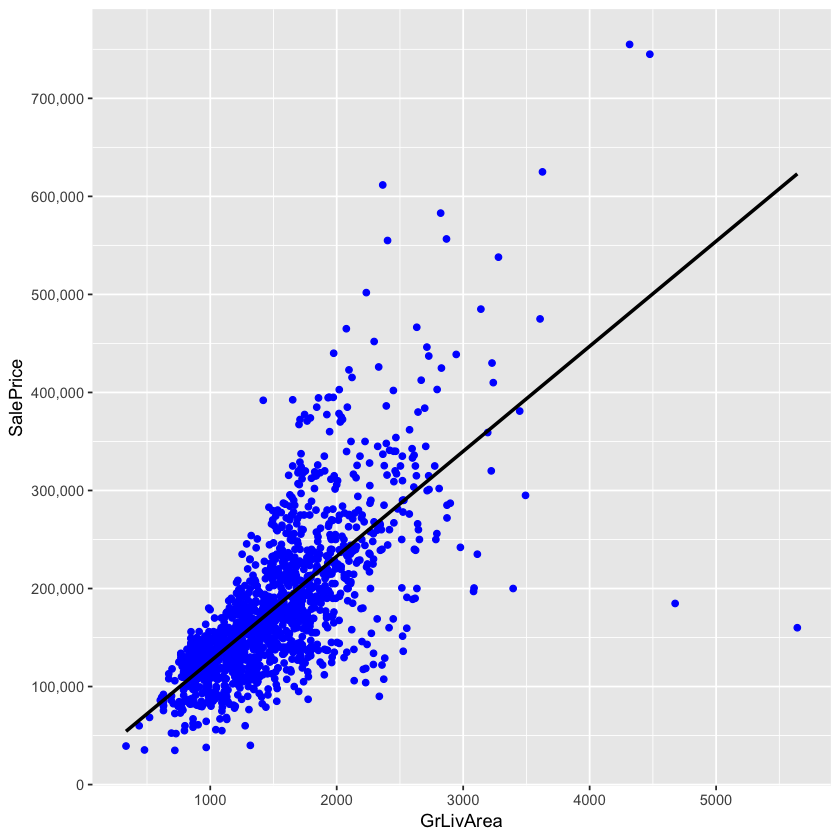

In [30]:
ggplot(data=all[!is.na(all$SalePrice),], 
       aes(x=GrLivArea, 
           y=SalePrice))+
    geom_point(col='blue') + 
    geom_smooth(method = "lm", 
                se=FALSE, color="black", 
                aes(group=1)) +
    scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) 
    #+ geom_text_repel(aes(label = ifelse(all$GrLivArea[!is.na(all$SalePrice)]>4500, 
    #                                   rownames(all), 
    #                                   '')))

Especially the two houses with really big living areas and low SalePrices seem outliers (houses 524 and 1299, see labels in graph). I will not take them out yet, as taking outliers can be dangerous. For instance, a low score on the Overall Quality could explain a low price. However, as you can see below, these two houses actually also score maximum points on Overall Quality. Therefore, I will keep houses 1299 and 524 in mind as prime candidates to take out as outliers.

In [31]:
all[c(524, 1299), c('SalePrice', 'GrLivArea', 'OverallQual')]

,SalePrice,GrLivArea,OverallQual
524,184750,4676,10
1299,160000,5642,10


---

### Missing data, label encoding, and factorizing variables

First of all, I would like to see which variables contain missing values.

In [32]:
NAcol <- which(colSums(is.na(all)) > 0)
sort(colSums(sapply(all[NAcol], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence    SalePrice  FireplaceQu 
        2909         2814         2721         2348         1459         1420 
 LotFrontage  GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType 
         486          159          159          159          159          157 
    BsmtCond BsmtExposure     BsmtQual BsmtFinType2 BsmtFinType1   MasVnrType 
          82           82           81           80           79           24 
  MasVnrArea     MSZoning    Utilities BsmtFullBath BsmtHalfBath   Functional 
          23            4            2            2            2            2 
 Exterior1st  Exterior2nd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF 
           1            1            1            1            1            1 
  Electrical  KitchenQual   GarageCars   GarageArea     SaleType 
           1            1            1            1            1

In [33]:
cat('There are', length(NAcol), 'columns with missing values')

There are 35 columns with missing values

Of course, the 1459 NAs in SalePrice match the size of the test set perfectly. This means that I have to fix NAs in 34 predictor variables.

I am going to fix the 34 predictors that contains missing values. I decided to use the “Tabs” option that knitr provides. 

Besides making sure that the NAs are taken care off, I have also converted character variables into ordinal integers if there is clear ordinality, or into factors if levels are categories without ordinality. I will convert these factors into numeric later on by using one-hot encoding (using the model.matrix function).

In [34]:
all$PoolQC[is.na(all$PoolQC)] <- 'None'

In [35]:
Qualities <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)

In [36]:
all$PoolQC<-as.integer(revalue(all$PoolQC, Qualities))
table(all$PoolQC)

The following `from` values were not present in `x`: Po, TA



   0    2    4    5 
2909    2    4    4 

In [37]:
all[all$PoolArea>0 & all$PoolQC==0, c('PoolArea', 'PoolQC', 'OverallQual')]

,PoolArea,PoolQC,OverallQual
2421,368,0,4
2504,444,0,6
2600,561,0,3


In [38]:
all$PoolQC[2421] <- 2
all$PoolQC[2504] <- 3
all$PoolQC[2600] <- 2